# EXERCICE 7 : REGRESSION LINEAIRE MULTIPLE AVEC REGULARISATION + VALIDATION CROISEE


Inspire de http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html


In [22]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


#### Génération de donnée synthétiques...

In [87]:

np.random.seed(31)

#... definition de n et p
n = 75
p =  200   #remarque : n<200 => necessite de selectionner des variables

#... simulation de X
X = np.random.randn(n, p) #remarque : on ne tient pas en compte les $beta_0$

#... generation du vecteur beta dans lequel seules 10 valeurs sont non-nulles
beta = 3 * np.random.randn(p)
#print(beta)
inds = np.arange(p)
np.random.shuffle(inds)
beta[inds[10:]] = 0 
#print(beta.shape)
#... simulation de y 
y = np.dot(X, beta) + (2.0 * np.random.normal(size=n))


# REMARQUE IMPORTANTE : y ne dépend que des variables i pour lesquelles beta[i] est non-nul


# ... coupe en deux les donnees en donnees d'apprentissage et donnes test
thresh=n // 2
X_train = X[thresh:]
y_train = y[thresh:]
X_test = X[:thresh]
y_test = y[:thresh]


print(X.shape)
print(X_train.shape)


(75, 200)
(38, 200)


#### Régression linéaire avec régularisation Lasso ...


In [31]:

from sklearn.linear_model import Lasso

alpha = 0.5
lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X_train, y_train)

y_pred_lasso = lasso_regressor.predict(X_test)
mse_score_lasso = mean_squared_error(y_test, y_pred_lasso)


####  Représentation du résultat


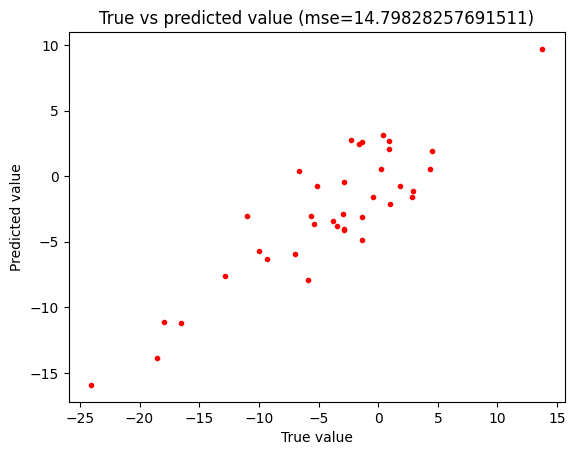

In [32]:
fig = plt.figure()
plt.plot(y_test, y_pred_lasso, 'r.')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('True vs predicted value (mse='+str(mse_score_lasso)+')')
plt.show()



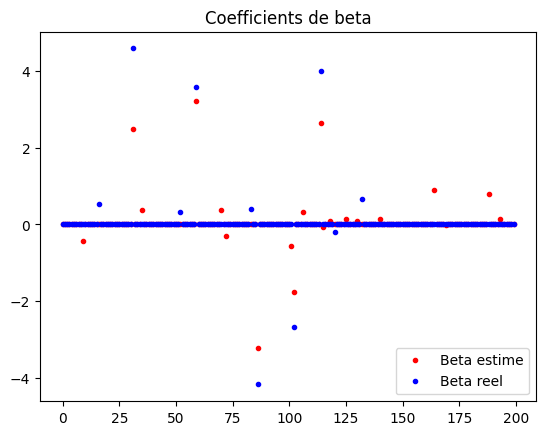

In [33]:

fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()



### <span style="color:blue">QUESTION 1</span> :

Jouez l'exemple avec  n=1000, n=100, n=75, n=50, n=25. Qu'en deduisez vous sur l'impact du nombre d'observations

### <span style="color:blue">REPONSE 1</span> :

plus n est grand plus l'estimation des beta est bonne


### <span style="color:blue">QUESTION 2</span> :

On garde n=75. Utilisez la validation croisee de type K-folds (typiquement 8-Folds) pour trouver le meilleur coefficient *alpha* au sens de la MSE. Pour chaque *alpha* testé, on gardera comme score la MSE moyenne obtenue sur tous les *folds*.

Remarque : la recherche d'un bon coefficient *alpha* pourra d'abord se faire sur une échelle exponentielle assez large (ex: 0.001, 0.01, 0.1, ...) puis être raffinée sur une échelle plus fine.  

### <span style="color:blue">REPONSE 2</span> :

In [ ]:

from sklearn.model_selection import KFold

#...
alpha = 0.23


lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X_train, y_train)

y_pred_lasso = lasso_regressor.predict(X_test)
mse_score_lasso = mean_squared_error(y_test, y_pred_lasso)

n_splits = 8

kf = KFold(n_splits, shuffle=True, random_state=42)

list_MSE = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X_train, y_train)
    y_pred_lasso = lasso_regressor.predict(X_test)
    mse_score_lasso = mean_squared_error(y_test, y_pred_lasso)

    list_MSE.append(mse_score_lasso)


print(list_MSE)
mean_MSE = sum(list_MSE)/len(list_MSE)

print("mean MSE : ", mean_MSE)



[5.026452411488071, 8.807321598236179, 7.444830168479191, 9.44242723509373, 6.128912296297567, 10.18433698428827, 6.228094324587132, 7.880225437385235]
mean MSE :  7.642825056981922


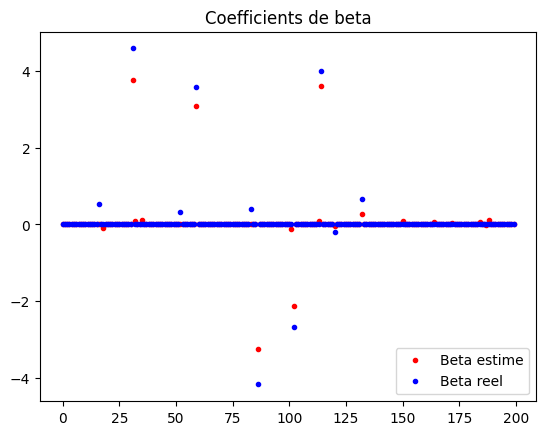

In [75]:
#représentation des coefficients estimés (lasso_regressor.coef_) et de ceux
#avec lesquels les données ont été simulées (beta)


#re-entrainer le modèle sur toutes les données avec le alpha choisi précedemment
lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X, y)

fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()


### <span style="color:blue">QUESTION 3</span> :

De manère alternative, codez et testez maintenant une sélection de type *forward* avec un critère de sélection *BIC*.

Comparez les résultats avec ceux obtenus à l'aide de la pénalisation LASSO.

### <span style="color:blue">REPONSE 3</span> :


In [101]:


from sklearn.linear_model import LinearRegression


nbr_obs = len(X[0,:])
n = len(X[:,0])

to_be_tested_p = [p_test for p_test in range(nbr_obs)]
selected_p = []

q = len(selected_p) + 1

def BIC(y_true, y_pred, n, q):
    return n * np.log(mean_squared_error(y_true, y_pred)) + np.log(n) * (q+1)

BIC_ref = []

X_m = []


for q in range(1, nbr_obs):

    BIC_q = []


    for p in to_be_tested_p:

        X_p = X[:,p]

        X_q = np.hstack((X_m, X_p))

        #print(X_q.ndim)

        lr = LinearRegression()

        if (X_q.ndim ==1):
            lr.fit(X_q[:, np.newaxis], y)
        else:
            lr.fit(X_q, y)

        indices = selected_p + [p]

        y_pred_q = lr.predict(X[:,indices])

        BIC_q.append([BIC(y, y_pred_q, n, q),p])

    
    #print("Liste des BIC : ", BIC_q)

    BIC_min = min(BIC_q, key=lambda x: x[0])[0]
    p_BIC_min = min(BIC_q, key=lambda x: x[0])[1]

    if (BIC_ref==[]):
        BIC_ref.append(BIC_min)
        to_be_tested_p.remove(p_BIC_min)
        selected_p.append(p_BIC_min)
        X_m = np.hstack((X_m, X[:, p_BIC_min]))
    elif (BIC_ref[-1]>=BIC_min):
        BIC_ref.append(BIC_min)
        to_be_tested_p.remove(p_BIC_min)
        selected_p.append(p_BIC_min)
        X_m = np.hstack((X_m, X[:, p_BIC_min]))
    else:
        print("Fin de boucle, q = ", q , " ; p sélectionnés : ", selected_p , " ; liste des BIC min : ", BIC_ref)
        break
    


ValueError: Found input variables with inconsistent numbers of samples: [150, 75]

In [99]:
indices = [] + [3,2]
print("x : ", X[indices, 0:3])

print(X.shape)

x :  [[-0.36642695 -0.19788106  0.6256126 ]
 [ 0.11925086  0.43254726  1.4941277 ]]
(75, 200)


In [ ]:
BIC : 